In [1]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt


import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score


import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [4]:
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [5]:
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [6]:
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(342478, 8)

In [7]:
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


## Recency

In [8]:
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [10]:
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [11]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [12]:
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [13]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [14]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


## Frequency

In [15]:
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


## Monetary

In [16]:
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [17]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


## RFM Table

In [18]:
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,LastPurshaceDate,Recency,Frequency
0,12346.0,2011-01-18,325,1
1,12747.0,2011-12-07,2,10
2,12748.0,2011-12-09,0,196
3,12749.0,2011-12-06,3,5
4,12820.0,2011-12-06,3,4


In [19]:
rfm_df = temp_df.merge(monetary_df,on='CustomerID')

rfm_df.set_index('CustomerID',inplace=True)

rfm_df.head()

,LastPurshaceDate,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,2011-01-18,325,1,77183.60
12747.0,2011-12-07,2,10,658.89
12748.0,2011-12-09,0,196,3739.23
12749.0,2011-12-06,3,5,98.35
12820.0,2011-12-06,3,4,58.20


In [20]:
rfm_df.to_csv (r'G:\Projects\Data Visualization Project\rfm_df.csv', index = False, header=True)

## Segmentation Using RFM Model

In [21]:
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  890679.54


In [22]:
customers_rank = rfm_df
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
customers_rank.head()

,LastPurshaceDate,Recency,Frequency,Monetary,Rank
CustomerID,,,,,
12346.0,2011-01-18,325,1,77183.60,2.0
12747.0,2011-12-07,2,10,658.89,183.0
12748.0,2011-12-09,0,196,3739.23,34.0
12749.0,2011-12-06,3,5,98.35,1140.0
12820.0,2011-12-06,3,4,58.20,1665.5


## Top Customers

In [23]:
customers_rank.sort_values('Rank',ascending=True)

,LastPurshaceDate,Recency,Frequency,Monetary,Rank
CustomerID,,,,,
16446.0,2011-12-09,0,2,168471.25,1.0
12346.0,2011-01-18,325,1,77183.60,2.0
15098.0,2011-06-10,182,3,39916.50,3.0
18102.0,2011-12-09,0,57,39646.45,4.0
17949.0,2011-12-08,1,44,28685.69,5.0
...,...,...,...,...,...
15503.0,2010-12-12,362,1,0.42,3859.5
15645.0,2011-11-21,18,1,0.42,3859.5
17914.0,2011-12-06,3,1,0.39,3861.5


In [24]:
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [25]:
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

## Appying RFM Score

In [26]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [27]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

In [28]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [29]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [30]:
rfm_segmentation.head()

,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,,
12346.0,2011-01-18,325,1,77183.60,2.0,1,1,4
12747.0,2011-12-07,2,10,658.89,183.0,4,4,4
12748.0,2011-12-09,0,196,3739.23,34.0,4,4,4
12749.0,2011-12-06,3,5,98.35,1140.0,4,3,3
12820.0,2011-12-06,3,4,58.20,1665.5,4,3,3


In [31]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,,
12346.0,2011-01-18,325,1,77183.60,2.0,1,1,4,114
12747.0,2011-12-07,2,10,658.89,183.0,4,4,4,444
12748.0,2011-12-09,0,196,3739.23,34.0,4,4,4,444
12749.0,2011-12-06,3,5,98.35,1140.0,4,3,3,433
12820.0,2011-12-06,3,4,58.20,1665.5,4,3,3,433


In [56]:
rfm_segmentation.to_csv (r'G:\Projects\Data Visualization Project\Main\rfm_segmentation.csv', index = True, header=True)

In [33]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,LastPurshaceDate,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,,
18102.0,2011-12-09,0,57,39646.45,4.0,4,4,4,444
17949.0,2011-12-08,1,44,28685.69,5.0,4,4,4,444
17450.0,2011-12-01,8,44,25953.51,6.0,4,4,4,444
16013.0,2011-12-06,3,45,17163.28,8.0,4,4,4,444
16333.0,2011-12-02,7,22,14418.96,9.0,4,4,4,444
15769.0,2011-12-02,7,25,11660.84,11.0,4,4,4,444
12901.0,2011-12-01,8,28,9230.45,12.0,4,4,4,444
13798.0,2011-12-08,1,56,7786.26,13.0,4,4,4,444
16684.0,2011-12-05,4,28,7700.08,14.0,4,4,4,444


In [34]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


In [35]:
d = {'segment':["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost", "Lost Customers", "Lost Cheat Customers"],"nofpeople":[356,752,966,64,9,353]}
key_segments = pd.DataFrame(data=d)

In [36]:
key_segments.to_csv (r'G:\Projects\Data Visualization Project\Main\key_segments.csv', index = False, header=True)

## Applying K Means With RFM Variables

In [37]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

,LastPurshaceDate,Recency,Frequency,Monetary,Rank
CustomerID,,,,,
12346.0,2011-01-18,325,1,77183.60,2.0
12747.0,2011-12-07,2,10,658.89,183.0
12748.0,2011-12-09,0,196,3739.23,34.0
12749.0,2011-12-06,3,5,98.35,1140.0
12820.0,2011-12-06,3,4,58.20,1665.5


In [38]:
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.279236,-0.027727,0.323089
Frequency,-0.279236,1.000000,0.156431,-0.458850
Monetary,-0.027727,0.156431,1.000000,-0.130520
Rank,0.323089,-0.458850,-0.130520,1.000000


In [39]:
rfm_data.to_csv (r'G:\Projects\Data Visualization Project\Main\rfm_data.csv', index = False, header=True)

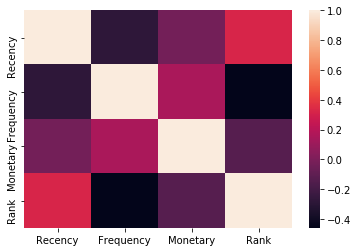

In [40]:
sns.heatmap(rfm_data.corr())

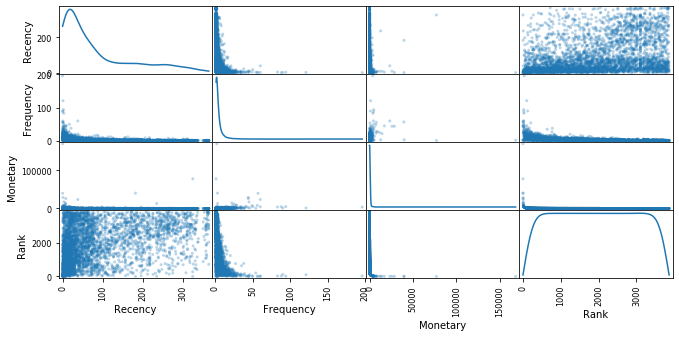

In [41]:
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

In [42]:
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [43]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [54]:
log_data.to_csv (r'G:\Projects\Data Visualization Project\Main\log_data.csv', index = False, header=True)

In [44]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


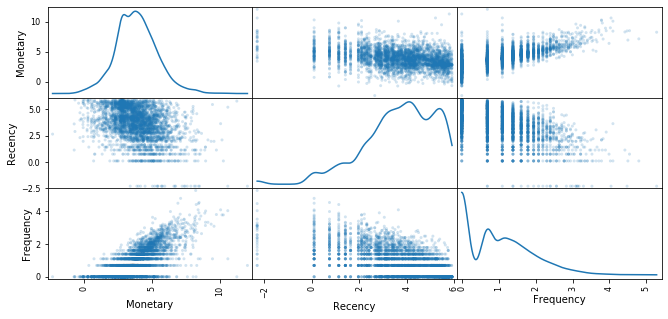

In [45]:
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');

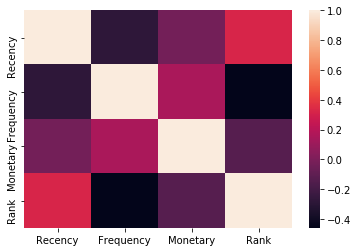

In [46]:
sns.heatmap(rfm_data.corr())

In [47]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.364351,0.715609
Recency,-0.364351,1.000000,-0.569951
Frequency,0.715609,-0.569951,1.000000


## K Means Algorithm

In [48]:

for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3894055410198746
For n_clusters = 3 The average silhouette_score is : 0.30380548886126
For n_clusters = 4 The average silhouette_score is : 0.309555875046299
For n_clusters = 5 The average silhouette_score is : 0.28990740408455407
For n_clusters = 6 The average silhouette_score is : 0.2953611972812875
For n_clusters = 7 The average silhouette_score is : 0.291290144968737
For n_clusters = 8 The average silhouette_score is : 0.29185982062266286
For n_clusters = 9 The average silhouette_score is : 0.29378332907877147


In [49]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.389


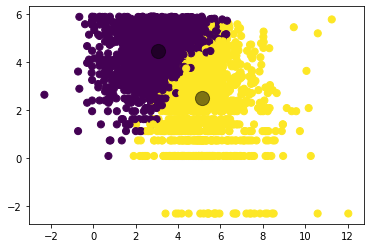

In [50]:
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [51]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2337,1526


In [52]:
d = {"Segment":["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost", "Lost Customers", "Lost Cheat Customers"], "RFM":["444","4X4","44X","244","144","111"], "Description":["Brought most recently, most often and spends the most","Buy more frequently", "Spends the most", "Havent purchased recently, but purchased frequently and spends the most", "Havent purchased recently, but purchased frequently and spends the most", "Last purchase long ago, purchased few and spent little"]}
rfm_des = pd.DataFrame(d)

In [53]:
rfm_des.to_csv (r'G:\Projects\Data Visualization Project\Main\rfm_des.csv', index = False, header=True)